In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

from tensorflow.keras import losses

from tensorflow.keras.utils import to_categorical

# 讀入MNIST數據集

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

In [4]:
x_train = x_train.reshape(-1, 28*28) / x_train.max()
x_test = x_test.reshape(-1, 28*28) / x_train.max()

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

# 建立VAE

In [5]:
#Encoder
x = Input(shape=(784,))

enc_1 = Dense(250, activation='sigmoid')
enc_2 = Dense(50, activation='sigmoid')
enc_mean = Dense(2)
enc_log_variance = Dense(2)

dec_3 = Dense(50, activation='sigmoid')
dec_2 = Dense(250, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

z_mean = enc_mean(enc_2(enc_1(x)))
z_log_variance = enc_log_variance(enc_2(enc_1(x)))

In [6]:
#抽樣函數
def sampling(args):
    z_mean, z_log_variance = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_variance) * epsilon

In [7]:
#Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_variance])

In [8]:
#Decoder
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [9]:
x_hat = dec_1(dec_2(dec_3(z)))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 250)          196250      input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           12550       dense[0][0]                      
                                                                 dense[1][0]                      
______________________________________________________________________________________________

In [10]:
#Loss函數
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_variance - K.square(z_mean) - K.exp(z_log_variance)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [11]:
VAE.compile(optimizer=Adam())

In [12]:
VAE.fit(x_train, batch_size=256, epochs=7)

Train on 60000 samples
Epoch 1/7
60000/60000 [==============================] - 5s 81us/sample - loss: 56.7277
Epoch 2/7
60000/60000 [==============================] - 4s 61us/sample - loss: 52.7580
Epoch 3/7
60000/60000 [==============================] - 4s 58us/sample - loss: 50.8070
Epoch 4/7
60000/60000 [==============================] - 4s 60us/sample - loss: 49.7059
Epoch 5/7
60000/60000 [==============================] - 3s 55us/sample - loss: 48.9561
Epoch 6/7
60000/60000 [==============================] - 3s 49us/sample - loss: 48.1467
Epoch 7/7
60000/60000 [==============================] - 4s 60us/sample - loss: 46.5033


In [13]:
VAE.save_weights('VAE_handwriting_model_weights.h5')

# VAE的Encoder視覺化呈現

In [14]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 250)               196250    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12550     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 208,902
Trainable params: 208,902
Non-trainable params: 0
_________________________________________________________________


In [15]:
idx = np.random.randint(x_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(x_train[idx: idx+1]).squeeze()}")

第 44588 圖的 latent 表示為 [-0.1944449   0.82182693]


In [16]:
indices = np.random.randint(x_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_train[indices])

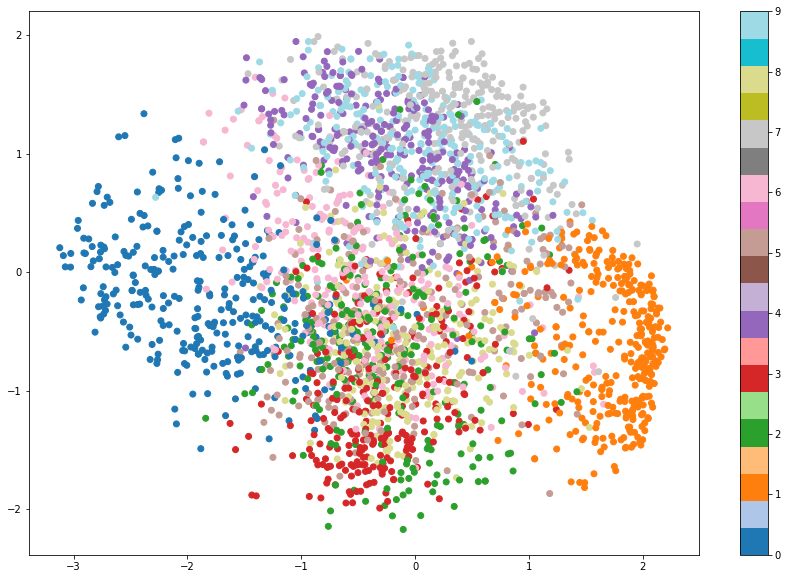

In [17]:
plt.figure(figsize=(15, 10))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

# VAE的Decoder視覺化呈現

In [18]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))
VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_5 (Dense)              (None, 250)               12750     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               196784    
Total params: 209,684
Trainable params: 209,684
Non-trainable params: 0
_________________________________________________________________


In [19]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [20]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

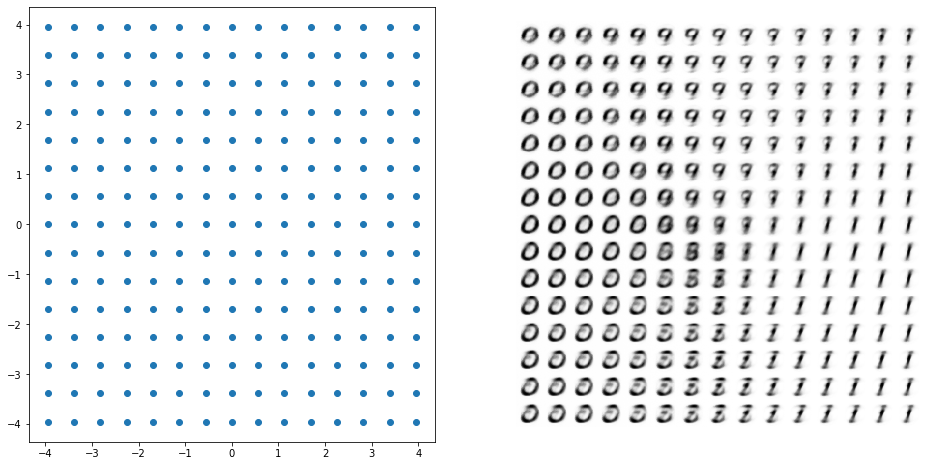

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()